# Initialise

## Imports

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Data Loadings

In [2]:
df_train_signal = pd.read_csv('../data/raw/train_signal.csv', converters={'x': json.loads, 'y': json.loads, 'z': json.loads})
df_test_signal = pd.read_csv('../data/raw/test_signal.csv', converters={'x': json.loads, 'y': json.loads, 'z': json.loads})
df_train_feature = pd.read_csv('../data/raw/train_feature.csv')
df_test_feature = pd.read_csv('../data/raw/test_feature.csv')

# Data Cleaning

The data `train_feature.csv` are a derivative of the data in `train_signal.csv`.

Therefore, we begin examining/investigating the **(Raw) Signal Data.**

## 1. Any NA values?

In [3]:
na_arrays = []
for i, r in df_train_signal.iterrows():
    for col in ['x', 'y', 'z']:
        nan_idx = np.argwhere(np.isnan(r[col]))
        if len(nan_idx) != 0:
            na_arrays.append((i, nan_idx[0][0], col))

#### Solution
Only 1 NA value.
Impute (*mean of 2 nearest neighbors*).

In [4]:
row, idx, axis = na_arrays[0]

df_train_signal[axis].iloc[row][idx]= np.mean([
    df_train_signal[axis].iloc[row][idx - 1],
    df_train_signal[axis].iloc[row][idx + 1]
])

#### Visualisation of Missing Value & Imputation

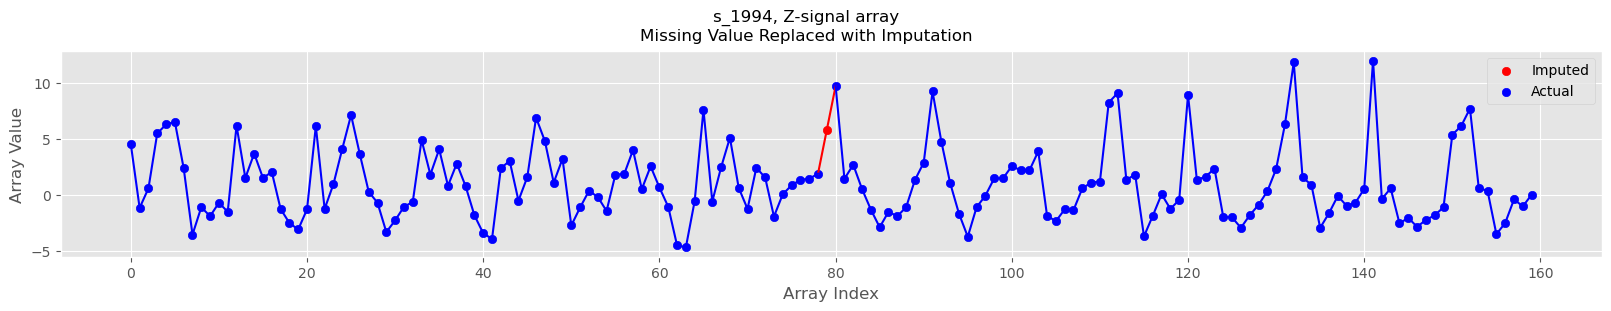

In [5]:
fig, ax = plt.subplots(figsize = (16, 3), layout = 'constrained')
idx = na_arrays[0][0]
sample = df_train_signal.loc[idx, ['x','y','z']]

for i, (x, color, label) in enumerate(
    zip(
        [range(78, 81), range(79), range(80, 160)],
        ['r', 'b', 'b'],
        ['Imputed', 'Actual', None])
    ):
    y = sample['z'][x[0] : x[-1] + 1]
    ax.plot(x, y, color = color)
    if i == 0:    
        x, y = 79, sample['z'][79]
    ax.scatter(x, y, color = color, label = label)

ax.set_xlabel('Array Index')
ax.set_ylabel('Array Value')

plt.suptitle('s_1994, Z-signal array\nMissing Value Replaced with Imputation')
plt.legend()
plt.show()

In [6]:
corr_matrix = np.round(np.corrcoef([sample['x'], sample['y'], sample['z']]), 5)
corrs = [corr_matrix[0, 1], corr_matrix[0, 2], corr_matrix[1, 2]]

df_train_feature.loc[idx, ['xy_corr', 'xz_corr', 'yz_corr']] = corrs

## 2. Anomalous rows? (e.g. full of 0's)

The dataset has rows wherein the signals are all-zero - Must investigate to see if these are anomalous rows.

**N.B.**: There are 2 subsets of "ALL-ZERO signal-data" - *ALL axis* and *SOME axis*. Plausibly, the second kind is not anomalous (There is some data), but the first kind is more obviously so. I investigate them seperately.

#### Investigation of "empty-rows"

In [7]:
def is_all_zero(signal):
    return np.all(np.array(signal) == 0)

is_zero = df_train_signal[['x', 'y', 'z']].map(is_all_zero)


# Splitting into subsets

# 1. Indices of Rows with ALL signals empty
zeros_all_axis = is_zero[is_zero.all(axis = 1)].index

# 2. Indices of Rows with SOME but NOT ALL signals empty (eXclusive OR)
zeros_xor_axis = is_zero[is_zero.any(axis = 1) & ~is_zero.all(axis = 1)].index

# [Indicies of Rows with NO all-zero signals]
zeros_no_axis = is_zero[~is_zero.any(axis = 1)].index

zeros_any_axis = is_zero[is_zero.any(axis = 1)].index

activity_split_no_zero = df_train_signal.iloc[zeros_no_axis][['id', 'activity']].groupby('activity').count()
activity_split_no_zero = activity_split_no_zero.rename(columns = {'id':'no_zero'})

activity_split_all_zero = df_train_signal.iloc[zeros_all_axis][['id', 'activity']].groupby('activity').count()
activity_split_all_zero = activity_split_all_zero.rename(columns= {'id':'all_zero'})

activity_split_some_zero = df_train_signal.iloc[zeros_xor_axis][['id', 'activity']].groupby('activity').count()
activity_split_some_zero = activity_split_some_zero.rename(columns = {'id':'some_not_all_zero'})

df_zeros = pd.merge(left = activity_split_no_zero,
                    right = activity_split_all_zero,
                    how = 'left', left_on='activity', right_on='activity')

df_zeros = pd.merge(left = df_zeros,
                    right = activity_split_some_zero,
                    how = 'left', left_on='activity', right_on='activity')

df_zeros

,no_zero,all_zero,some_not_all_zero
activity,,,
Downstairs,587,NaN,NaN
Jogging,2043,67.0,2.0
Sitting,393,NaN,NaN
Standing,295,NaN,NaN
Upstairs,720,1.0,NaN
Walking,2401,NaN,NaN


#### Conclusion
* Activities of rows with (ALL-AXIS = ALL-ZERO) are **all either "Jogging" or "Upstairs"**
* Activites of rows with (SOME-AXIS = ALL-ZERO) are ***all* "Jogging"**

"Jogging" is a placeholder label?

#### Solution
1. **Feature-based Model:** *Exclude* Rows from training-data, and apply a rule with "Placeholder"/"Default" logic to handle corrupt samples
2. **Signal-based (End-to-end / DL) Model:** 


####  Visualising the "SOME all-zero" signals
Here's a visual demonstration that the (SOME-AXIS = ALL-ZERO) rows are 

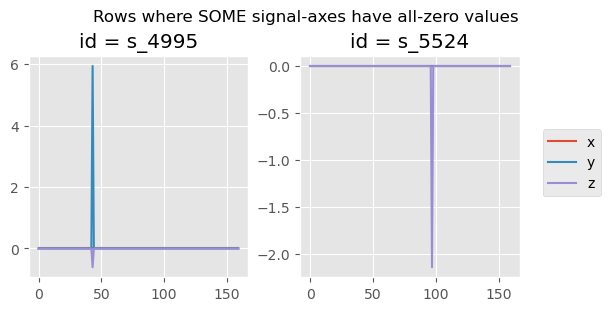

In [8]:
fig, axs = plt.subplots(ncols=len(zeros_xor_axis), nrows=1, figsize = (6, 3),   layout = 'constrained')

for i, ax in zip(zeros_xor_axis, axs):
    sample = df_train_signal.iloc[i]
    for c in ['x', 'y', 'z']:
        ax.plot(sample[c], label = c)
        ax.set_title(f'id = s_{i + 1}')
plt.suptitle('Rows where SOME signal-axes have all-zero values')
plt.legend(bbox_to_anchor = [1.4, 0.7], ncol = 1)
plt.show()

#### Further Analysis of 0's
These *can* be excluded because all-zero is anamalous. We can investigate signals with increasing amount of 0's in them, and what we see is that signals with large numbers of 0's are relatively much more infrequent than signals with non-zero elements.

**The below plot** shows this trend: 
* On the x-axis is the number of 0's in an axis (i.e. (min, max) = (0, 160))
* On the y-axis is the log(number of rows) (I've taken the log purely for visual demonstration)
* 3 Lines are plotted: 
    1. **All-axis** have $e^y$ rows where the count(zero-elements) > x.
    2. **Any-axis** has $e^y$ rows where the count(zero-elements) > x.
    3. **Horizontal Line** at y = log(70) (Number of rows with any axis being all-zero signals)

In [9]:
# def count_zero(signal, i):
#     return sum(np.array(signal) == 0) > i

# counts_any, counts_all = [], []
# for i in range(161):
#     count_zeros = df_train_signal[['x', 'y', 'z']].map(lambda sig: count_zero(sig, i))
#     counts_any.append(len(count_zeros[count_zeros.any(axis = 1)]))
#     counts_all.append(len(count_zeros[count_zeros.all(axis = 1)]))

# fig, ax = plt.subplots(figsize = (10, 5), layout = 'constrained')
# colors = sns.palettes.color_palette('pastel', 3)

# ax.plot(list(range(161)), np.log(counts_all), color = colors[0], label = 'All Axes')
# ax.plot(list(range(161)), np.log(counts_any), color = colors[1], label = 'Any Axes')

# ax.axhline(np.log(70),color = colors[2], linestyle = 'dashed', alpha = 0.5, label = 'Rows to Exclude')

# ax.set_xlabel('No. of elements in signal = 0')
# ax.set_ylabel('Log(No. of Rows)')
# ax.set_title('Investigating 0\'s: Plot of Log(Rows) where No. of signal-elements are 0')

# plt.legend()
# plt.show()

#### Are these instances user-specific?

It is plausible that certain users restricted visibility on their data for certain activities (e.g. "Jogging").

In [10]:
# Rows with any all-zero signals
rows_with_zero_signals = df_train_signal.iloc[is_zero[is_zero.any(axis=1)].index]

# Group by user and count rows where activity is "Jogging"
jogging_zero_counts = rows_with_zero_signals[rows_with_zero_signals['activity'] == 'Jogging'].groupby('user').size()
jogging_zero_counts = jogging_zero_counts.rename('jogging_zero_rows')

# Group by user and count total "Jogging" rows
total_jogging_counts = df_train_signal[df_train_signal['activity'] == 'Jogging'].groupby('user').size()
total_jogging_counts = total_jogging_counts.rename('total_jogging_rows')

# Combine the two counts into a single DataFrame
jogging_analysis = pd.concat([jogging_zero_counts, total_jogging_counts], axis=1)
jogging_analysis[jogging_analysis['jogging_zero_rows'].notna()]

,jogging_zero_rows,total_jogging_rows
user,,
u_15,8.0,99
u_18,9.0,99
u_20,10.0,106
u_21,8.0,102
u_22,18.0,107
u_3,16.0,101


Users with *any* all-zero "Jogging" rows also have many instances of non-zero data.

It's therefore not very meaningful to suggest that there is any specific user-interaction on these anomalies.

#### Drop Rows

Exclude rows from training-data.

In [11]:
df_train_feature = df_train_feature.drop(index = is_zero[is_zero.any(axis = 1)].index)
df_train_signal = df_train_signal.drop(index = is_zero[is_zero.any(axis = 1)].index)

#### IMPORTANT: Exclusion in Test
Since I'm classifying these all-zero samples manually, we also need to extract & exclude them from the Test data that the Model is using for predictions.

In [12]:
is_zero_test = df_test_signal[['x', 'y', 'z']].map(is_all_zero)
is_zero_test_indices = is_zero_test[is_zero_test.any(axis = 1)].index

ids_allzero = df_test_signal.iloc[is_zero_test_indices]['id'].copy()
df_testcases_allzero = pd.DataFrame(data = {
    'id': ids_allzero,
    'predicted': ['Jogging']*len(ids_allzero)}
    ).to_csv('../data/processed/predictions_allzero.csv', index = False)

df_test_signal = df_test_signal.drop(index = is_zero_test_indices)
df_test_feature = df_test_feature.drop(index = is_zero_test_indices)

## 3. Anomalous Rows in Test-data?
Checking both `test_feature.csv` and  `test_signal.csv`, we find that 2 rows in the feature-test-data have "mag_energy" are *infinite*.

In [13]:
inf_indices = df_test_feature[df_test_feature['mag_energy'] == np.inf].index
print(inf_indices)

Index([1401, 1571], dtype='int64')


#### Solution
Regardless of why these are *infinite* in the dataset, they can be re-calculated - after all, they derive from the raw-signal-data.

*mag_energy* is a measure of magnitude across the entire 8-second signal, placing greater weight on larger magnitudes (by squaring). Mathematically speaking,

$\text{mag\_energy} = \sum_{t=1}^{N} \left( \text{mag}(t)^2 \right)$ where $\text{mag}(t)=\sqrt{x_t^2 + y_t^2 + z_t^2}$ 

Given that the rows at `test_signal.csv` are sound, we can simply calculate the value & impute the *np.inf* value in `test_feature.csv`.

In [14]:
def get_mag_energy(df_row, mags = None):
    row = np.array([
        df_row['x'],
        df_row['y'],
        df_row['z']]).transpose()
    mags = np.sqrt(np.sum(np.square(row), axis = 1))
    energy = np.sum(np.square(mags))
    energy = np.round(energy / 10) * 10 # Nearest 10 Approximation to training-data
    return energy

#### Sanity Check

We can run a quick sanity check to determine whether the calculations are close enough, by comparing the calculated/actual values in the **training data**. 

The calculated values are sufficiently accurate in my view (largest deviation is at 0.3631% of the actual value).

In [15]:

print('i | calculated_mag | actual_mag')
for i in range(5):
    print(i, get_mag_energy(df_train_signal.iloc[i]), df_train_feature['mag_energy'].iloc[i])
mismatch_count = 0
errors = []
diffs = []
for i in range(len(df_train_signal)):
    calc = get_mag_energy(df_train_signal.iloc[i])
    actual = df_train_feature['mag_energy'].iloc[i]
    if (calc != actual) and (actual != 0):
        diff = np.abs(calc-actual)
        pc_error = (diff / actual)  * 100
        diffs.append(diff)
        errors.append(pc_error)
        mismatch_count += 1
        # print(f"Mismatch at {i}: calc={calc}, actual={actual}, diff = {diff}, pc_error = {np.round(pc_error, 3)}%")
print(f"Recalculated MAG_energy \nMismatches: {mismatch_count} of {len(df_train_signal)} Samples\nmax_diff = {max(diffs)}\nmax_pc_error = {np.round(max(errors), 4)}%")


i | calculated_mag | actual_mag
0 38750.0 38750.0
1 19500.0 19500.0
2 37010.0 37020.0
3 23050.0 23060.0
4 22660.0 22660.0
Recalculated MAG_energy 
Mismatches: 3022 of 6439 Samples
max_diff = 70.0
max_pc_error = 0.3631%


#### Conclusion
Impute the values based on the calculation.

In [16]:
for idx in inf_indices:
    row = df_test_signal.iloc[idx]
    corrected_value = get_mag_energy(row)
    df_test_feature.loc[idx, 'mag_energy'] = corrected_value

# Extracting Data

In [17]:
df_test_feature.to_csv('../data/processed/test_feature_clean.csv', index = False)
df_train_feature.to_csv('../data/processed/train_feature_clean.csv', index = False)

df_train_signal.to_csv('../data/processed/train_signal_clean.csv', index = False)
df_test_signal.to_csv('../data/processed/test_signal_clean.csv', index = False)